In [1]:
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [2]:
def noised_image(image,power_of_noise):
    noised_image = image + 3 * image.std() * np.random.random(image.shape) * power_of_noise
    return noised_image

In [3]:
x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test  = np.reshape(x_test,  (len(x_test),  32, 32, 3))

In [4]:
import random

#create noised train dataset
train_noise = []
train_labels = []

for i in range(x_train.shape[0]):
    power = random.randint(10,25)
    power = power / 100.
    img = noised_image(x_train[i], power)
    train_noise.append(img)
    train_labels.append(x_train[i])

train_noise = np.array(train_noise)
train_labels = np.array(train_labels)

train_labels.shape

(50000, 32, 32, 3)

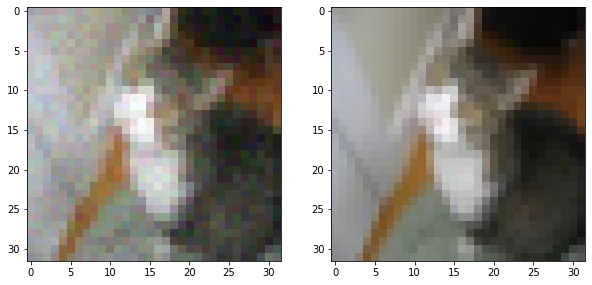

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10,10))

axes[0].imshow(train_noise[101])
axes[1].imshow(train_labels[101])

In [6]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Activation, BatchNormalization
from keras.models import Model

In [7]:
def create_conv_ae():

    # encoder
    input_img = Input(shape=(32, 32, 3))

    conv1_1 = Conv2D(32, (3, 3), padding='same')(input_img)
    relu1_1 = Activation('relu')(conv1_1)
    conv1_2 = Conv2D(32, (3, 3), padding='same')(relu1_1)
    relu1_2 = Activation('relu')(conv1_2)
    pool1 = MaxPooling2D((2, 2), padding='same')(relu1_2)

    conv2_1 = Conv2D(64, (3, 3), padding='same')(pool1)
    b2_1 = BatchNormalization()(conv2_1)
    relu2_1 = Activation('relu')(b2_1)

    conv2_2 = Conv2D(64, (3, 3), padding='same')(relu2_1)
    b2_2 = BatchNormalization()(conv2_2)
    relu2_2 = Activation('relu')(b2_2)
    pool2 = MaxPooling2D((2, 2), padding='same')(relu2_2)

    conv3_1 = Conv2D(128, (3, 3), padding='same')(pool2)
    b3_1 = BatchNormalization()(conv3_1)
    relu3_1 = Activation('relu')(b3_1)

    conv3_2 = Conv2D(128, (3, 3), padding='same')(relu3_1)
    b3_2 = BatchNormalization()(conv3_2)
    encoded = Activation('relu')(b3_2)
    enc_dim = encoded.shape[1:]

    encoder = Model(input_img, encoded, name = 'encoder')

    # decoder
    input_encoded = Input(shape=enc_dim)

    conv4_1 = Conv2D(128, (3, 3), padding='same')(input_encoded)
    b4_1 = BatchNormalization()(conv4_1)
    relu4_1 = Activation('relu')(b4_1)

    conv4_2 = Conv2D(128, (3, 3), padding='same')(relu4_1)
    b4_2 = BatchNormalization()(conv4_2)
    relu4_2 = Activation('relu')(b4_2)
    up1 = UpSampling2D((2, 2), interpolation='nearest')(relu4_2)

    conv5_1 = Conv2D(64, (3, 3), padding='same')(up1)
    b5_1 = BatchNormalization()(conv5_1)
    relu5_1 = Activation('relu')(b5_1)

    conv5_2 = Conv2D(64, (3, 3), padding='same')(relu5_1)
    b5_2 = BatchNormalization()(conv5_2)
    relu5_2 = Activation('relu')(b5_2)
    up2 = UpSampling2D((2, 2), interpolation='nearest')(relu5_2)

    conv6_1 = Conv2D(32, (3, 3), padding='same')(up2)
    b6_1 = BatchNormalization()(conv6_1)
    relu6_1 = Activation('relu')(b6_1)
    
    conv6_2 = Conv2D(32, (3, 3), padding='same')(relu6_1)
    b6_2 = BatchNormalization()(conv6_2)
    relu6_2 = Activation('relu')(b6_2)
    conv6_3 = Conv2D(3, (1, 1), padding='same')(relu6_2)
    decoded = Activation('sigmoid')(conv6_3)

    decoder = Model(input_encoded, decoded, name = 'decoder')

    #autoencoder
    autoencoder = Model(input_img, decoder(encoder(input_img)), name = 'autoencoder')

    return encoder, decoder, autoencoder

In [8]:
encoder, decoder, autoencoder = create_conv_ae()
autoencoder.compile(optimizer='adam', loss='mse')

In [16]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 8, 8, 128)         287200    
                                                                 
 decoder (Functional)        (None, 32, 32, 1)         425537    
                                                                 
Total params: 712,737
Trainable params: 711,905
Non-trainable params: 832
_________________________________________________________________


In [9]:
#create noised test dataset
test_noise = []
test_labels = []

for i in range(x_test.shape[0]):
    power = random.randint(10,20)
    power = power / 100.
    img = noised_image(x_test[i], power)
    test_noise.append(img)
    test_labels.append(x_test[i])

test_noise = np.array(test_noise)
test_labels = np.array(test_labels)

test_labels.shape

(10000, 32, 32, 3)

In [11]:
autoencoder.fit(x=train_noise, y=train_labels,
                epochs=15,
                batch_size=64,
                shuffle=True,
                validation_data=(test_noise, test_labels))

Epoch 1/15
782/782 [==============================] - 15s 19ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 2/15
782/782 [==============================] - 15s 19ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 3/15
782/782 [==============================] - 15s 19ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/15
782/782 [==============================] - 15s 19ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 5/15
782/782 [==============================] - 15s 19ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 6/15
782/782 [==============================] - 15s 19ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/15
782/782 [==============================] - 15s 20ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/15
782/782 [==============================] - 15s 19ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 9/15
782/782 [==============================] - 15s 19ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 10/15
782/782 [==============================] - 15s 19ms/step - loss: 0.001

In [12]:
predicted = autoencoder.predict(test_noise[:32])

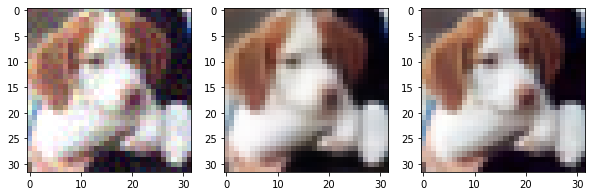

In [37]:
id = 16

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (10,10))
img = np.reshape(predicted[id], (32, 32, 3))
axes[0].imshow(test_noise[id]) #noised image
axes[1].imshow(img) #predicted
axes[2].imshow(test_labels[id]) #test label

In [ ]:
autoencoder.save('/content/drive/MyDrive/Colab Notebooks/ae')

In [39]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_images(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [40]:
n = 10

imgs = test_noise[:n]
encoded_imgs = encoder.predict(imgs, batch_size=n)

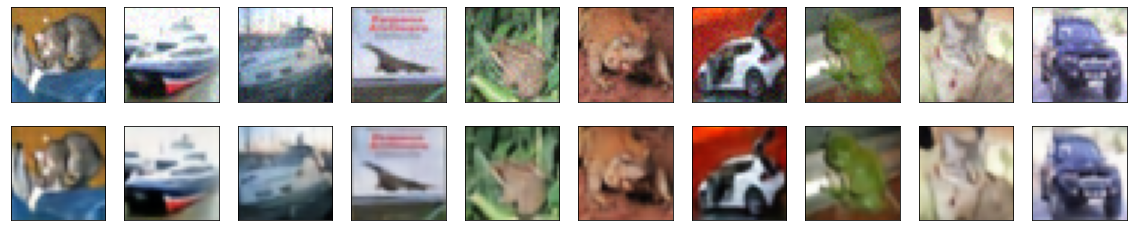

In [41]:
decoded_imgs = decoder.predict(encoded_imgs, batch_size=n)
plot_images(imgs, decoded_imgs)